In [19]:
# Mount Google Drive to access dataset
from google.colab import drive
drive.mount('/content/drive')
import os
#os.environ["CUDA_VISIBLE_DEVICES"] = "-1"


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [20]:
import tensorflow as tf
print(tf.__version__)
print("GPUs:", tf.config.list_physical_devices("GPU"))

2.18.0
GPUs: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [21]:
!nvidia-smi

Mon Jun  9 23:40:19 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA A100-SXM4-40GB          Off |   00000000:00:04.0 Off |                    0 |
| N/A   30C    P0             49W /  400W |       5MiB /  40960MiB |      0%      Default |
|                                         |                        |             Disabled |
+-----------------------------------------+-----

In [22]:
# for Vimala and Sean
%cd /content/drive/MyDrive/cs231n/student-radar/paper
# for Susan
# %cd /content/drive/MyDrive/student-radar/paper/
!pwd
!ls

/content/drive/MyDrive/cs231n/student-radar/paper
/content/drive/MyDrive/cs231n/student-radar/paper
analysis	      plots		   TrainOriginal-rghsxmf6.ipynb
Analysis.ipynb	      README.md		   TrainStudent-9idubkqi.ipynb
checkpoints	      src		   TrainStudent-h1k2x95j.ipynb
data		      summary.png	   TrainStudent.ipynb
generated_traces.png  summary.svg	   wandb
Generate.ipynb	      TrainBoth.ipynb
Plot.ipynb	      TrainOriginal.ipynb


In [23]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '0' # set to 1 for less verbosity (keeps warnings and errors but discards info)

In [24]:
!pip install h5py matplotlib scipy scikit-learn wandb polarTransform pyqtgraph PyQt5

# Generate RA Map

In [25]:
import os
import numpy as np
import matplotlib.pyplot as plt
import sys
sys.path.append('/content/drive/MyDrive/cs231n/student-radar/paper/src/postprocessing/rota2030-bsm-rsp')

from src.Signal_Processing import Radar_Cube
from src.bsd_lib import BlindspotDetector

file_real = '/content/drive/MyDrive/cs231n/student-radar/paper/data/real/EXP_17_M.h5'
output_dir = '/content/drive/MyDrive/cs231n/student-radar/paper/plots/real_ra'
ra_output_npy = '/content/drive/MyDrive/cs231n/student-radar/paper/data/real/real_ra.npy'
os.makedirs(output_dir, exist_ok=True)

radar = Radar_Cube(file_real, dmax=30)
detector = BlindspotDetector(radar)

radar.gen_Cube(0)
radar._attrs['nLoop'] = 1

n_frames = int(radar._attrs['maxFrm'])
print(f"[INFO] Total frames in file: {n_frames}")

ra_maps = []

for frame_id in range(n_frames):
    print(f"[INFO] Processing frame {frame_id+1}/{n_frames}")

    try:
        radar.gen_Cube(frame_id)  # load one radar cube
        RP = radar.range_Profile()['Data']  # (128, 16, 1024)
        RAimg = radar.range_Azimuth()['Data']  # (Azimuth, Range)

        ra_maps.append(RAimg)

        # === Optional: save image
        plt.imsave(f"{output_dir}/frame_{frame_id:04d}.png", RAimg, cmap='viridis')
    except Exception as e:
        print(f"[WARN] Skipping frame {frame_id}: {e}")

# === Save all RA maps as .npy file
ra_maps = np.array(ra_maps)
np.save(ra_output_npy, ra_maps)
print(f"[DONE] Saved {len(ra_maps)} RA maps to: {ra_output_npy}")


[INFO] Total frames in file: 113
[INFO] Processing frame 1/113
[INFO] Processing frame 2/113
[INFO] Processing frame 3/113
[INFO] Processing frame 4/113
[INFO] Processing frame 5/113
[INFO] Processing frame 6/113
[INFO] Processing frame 7/113
[INFO] Processing frame 8/113
[INFO] Processing frame 9/113
[INFO] Processing frame 10/113
[INFO] Processing frame 11/113
[INFO] Processing frame 12/113
[INFO] Processing frame 13/113
[INFO] Processing frame 14/113
[INFO] Processing frame 15/113
[INFO] Processing frame 16/113
[INFO] Processing frame 17/113
[INFO] Processing frame 18/113
[INFO] Processing frame 19/113
[INFO] Processing frame 20/113
[INFO] Processing frame 21/113
[INFO] Processing frame 22/113
[INFO] Processing frame 23/113
[INFO] Processing frame 24/113
[INFO] Processing frame 25/113
[INFO] Processing frame 26/113
[INFO] Processing frame 27/113
[INFO] Processing frame 28/113
[INFO] Processing frame 29/113
[INFO] Processing frame 30/113
[INFO] Processing frame 31/113
[INFO] Processi

In [26]:
import os
import sys
import numpy as np
import matplotlib.pyplot as plt

sys.path.append('/content/drive/MyDrive/cs231n/student-radar/paper/src/postprocessing/rota2030-bsm-rsp')

from src.Signal_Processing import Radar_Cube
from src.bsd_lib import BlindspotDetector

def generate_ra_maps(input_data, output_dir=None, output_npy=None):
    file_real = "/content/drive/MyDrive/cs231n/student-radar/paper/data/real/EXP_17_M.h5"

    os.makedirs(os.path.dirname(output_npy), exist_ok=True)

    data = np.load(input_data)
    print("[INFO] Loaded generated data:", data.shape)

    radar = Radar_Cube(file_real, dmax=30)
    _ = BlindspotDetector(radar)

    radar.gen_Cube(0)
    radar._attrs['nLoop'] = 1

    ra_maps = []

    for i, frame in enumerate(data):
        try:
            print(f"[INFO] Processing frame {i+1}/{len(data)}")

            radar.range_Profile(frame)
            RAimg = radar.range_Azimuth()['Data']
            ra_maps.append(RAimg)
        except Exception as e:
            print(f"[WARN] Skipping frame {i}: {e}")

    # Save all RA maps to .npy
    ra_maps = np.array(ra_maps)
    np.save(output_npy, ra_maps)
    print(f"[DONE] Saved {len(ra_maps)} RA maps to: {output_npy}")


In [27]:
# Original model RA map
generate_ra_maps(
    # You should be able to find the input data path from the generated data file
    input_data="/content/drive/MyDrive/cs231n/student-radar/paper/data/generated/original/model-rghsxmf6/generations_10000/generator_data.npy",
    output_dir="/content/drive/MyDrive/cs231n/student-radar/paper/plots/original_ra",
    output_npy="/content/drive/MyDrive/cs231n/student-radar/paper/data/generated/original_ra.npy",
)


Streaming output truncated to the last 5000 lines.
[INFO] Processing frame 5002/10000
[INFO] Processing frame 5003/10000
[INFO] Processing frame 5004/10000
[INFO] Processing frame 5005/10000
[INFO] Processing frame 5006/10000
[INFO] Processing frame 5007/10000
[INFO] Processing frame 5008/10000
[INFO] Processing frame 5009/10000
[INFO] Processing frame 5010/10000
[INFO] Processing frame 5011/10000
[INFO] Processing frame 5012/10000
[INFO] Processing frame 5013/10000
[INFO] Processing frame 5014/10000
[INFO] Processing frame 5015/10000
[INFO] Processing frame 5016/10000
[INFO] Processing frame 5017/10000
[INFO] Processing frame 5018/10000
[INFO] Processing frame 5019/10000
[INFO] Processing frame 5020/10000
[INFO] Processing frame 5021/10000
[INFO] Processing frame 5022/10000
[INFO] Processing frame 5023/10000
[INFO] Processing frame 5024/10000
[INFO] Processing frame 5025/10000
[INFO] Processing frame 5026/10000
[INFO] Processing frame 5027/10000
[INFO] Processing frame 5028/10000
[INF

In [28]:
# Student model RA map
generate_ra_maps(
    # You should be able to find the input data path from the generated data file from above
    input_data="/content/drive/MyDrive/cs231n/student-radar/paper/data/generated/student/model-h1k2x95j/generations_10000/generator_data.npy",
    output_dir="/content/drive/MyDrive/cs231n/student-radar/paper/plots/student_ra",
    output_npy="/content/drive/MyDrive/cs231n/student-radar/paper/data/generated/student_ra.npy",
)

Streaming output truncated to the last 5000 lines.
[INFO] Processing frame 5002/10000
[INFO] Processing frame 5003/10000
[INFO] Processing frame 5004/10000
[INFO] Processing frame 5005/10000
[INFO] Processing frame 5006/10000
[INFO] Processing frame 5007/10000
[INFO] Processing frame 5008/10000
[INFO] Processing frame 5009/10000
[INFO] Processing frame 5010/10000
[INFO] Processing frame 5011/10000
[INFO] Processing frame 5012/10000
[INFO] Processing frame 5013/10000
[INFO] Processing frame 5014/10000
[INFO] Processing frame 5015/10000
[INFO] Processing frame 5016/10000
[INFO] Processing frame 5017/10000
[INFO] Processing frame 5018/10000
[INFO] Processing frame 5019/10000
[INFO] Processing frame 5020/10000
[INFO] Processing frame 5021/10000
[INFO] Processing frame 5022/10000
[INFO] Processing frame 5023/10000
[INFO] Processing frame 5024/10000
[INFO] Processing frame 5025/10000
[INFO] Processing frame 5026/10000
[INFO] Processing frame 5027/10000
[INFO] Processing frame 5028/10000
[INF

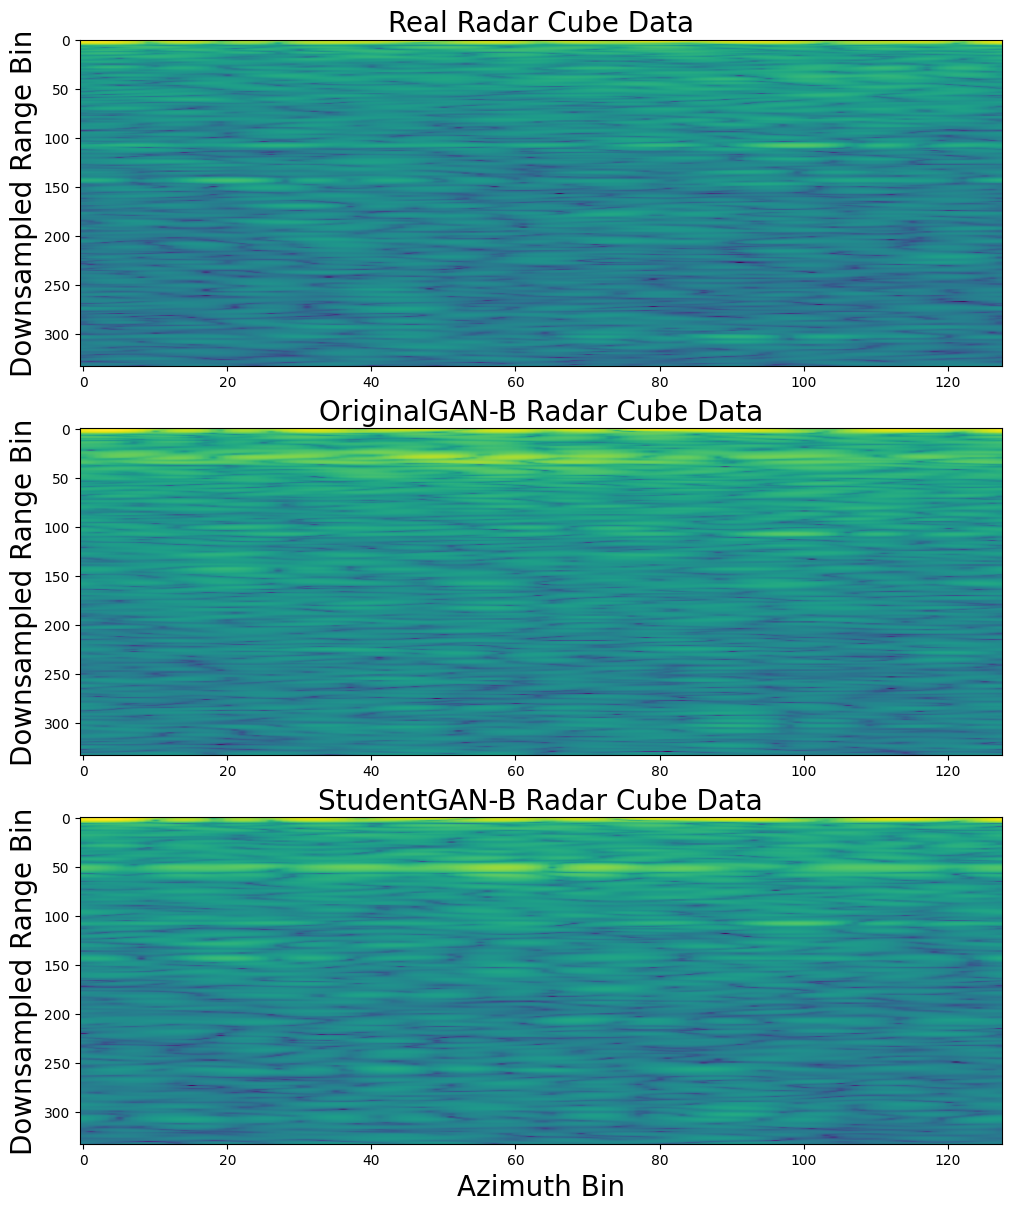

In [72]:
import numpy as np
import matplotlib.pyplot as plt

real_ra = np.load('/content/drive/MyDrive/cs231n/student-radar/paper/data/real/real_ra.npy')
original_ra = np.load('/content/drive/MyDrive/cs231n/student-radar/paper/data/generated/original_ra.npy')
student_ra = np.load('/content/drive/MyDrive/cs231n/student-radar/paper/data/generated/student_ra.npy')

frame_id = 0
real_img = real_ra[frame_id]
original_img = original_ra[frame_id]
student_img = student_ra[frame_id]

# === Plot ===
fig, axes = plt.subplots(3, 1, figsize=(10, 12), constrained_layout=True)

axes[0].imshow(real_img, aspect='auto', cmap='viridis')
axes[0].set_title("Real Radar Cube Data", fontsize=20)
axes[0].set_ylabel("Downsampled Range Bin", fontsize=20)

axes[1].imshow(original_img, aspect='auto', cmap='viridis')
axes[1].set_title("OriginalGAN-B Radar Cube Data", fontsize=20)
axes[1].set_ylabel("Downsampled Range Bin", fontsize=20)

axes[2].imshow(student_img, aspect='auto', cmap='viridis')
axes[2].set_title("StudentGAN-B Radar Cube Data", fontsize=20)
axes[2].set_ylabel("Downsampled Range Bin", fontsize=20)
axes[2].set_xlabel("Azimuth Bin", fontsize=20)

plt.savefig('/content/drive/MyDrive/cs231n/student-radar/paper/plots/ra_comparison.png', dpi=600)


# Signal plot


In [63]:
import numpy as np
import matplotlib.pyplot as plt

real_data_path = '/content/drive/MyDrive/cs231n/student-radar/paper/data/preprocessed/EXP_17_M_chirps.npy'
original_data_path = '/content/drive/MyDrive/cs231n/student-radar/paper/data/generated/original/model-rghsxmf6/generations_10000/generator_data.npy'
student_data_path = '/content/drive/MyDrive/cs231n/student-radar/paper/data/generated/student/model-h1k2x95j/generations_10000/generator_data.npy'

real_data = np.load(real_data_path)
original_data = np.load(original_data_path)
student_data = np.load(student_data_path)

frame_id = 0
real_frame = real_data[frame_id].T
original_frame = original_data[frame_id]
student_frame = student_data[frame_id]

a, b = -1, 1

data_min = -3884.0
data_max = 4772.0


def denormalize(data):
    data = np.subtract(data, a)                          # Step 1: undo shift
    data = np.divide(data, (b - a))                      # Step 2: undo scale to [0, b-a]
    data = np.multiply(data, (data_max - data_min))      # Step 3: rescale to original range
    data = np.add(data, data_min)                        # Step 4: shift back to original min
    return data

original_frame_unnorm = denormalize(original_frame).T
student_frame_unnorm = denormalize(student_frame).T

In [52]:
data_min = train_data.min()
data_max = train_data.max()

In [56]:
data_max

np.float32(1.0)

In [66]:
real_frame.shape

(1024, 16)

In [65]:
original_frame_unnorm.shape

(1024, 16)

In [64]:
student_frame_unnorm.shape

(1024, 16)

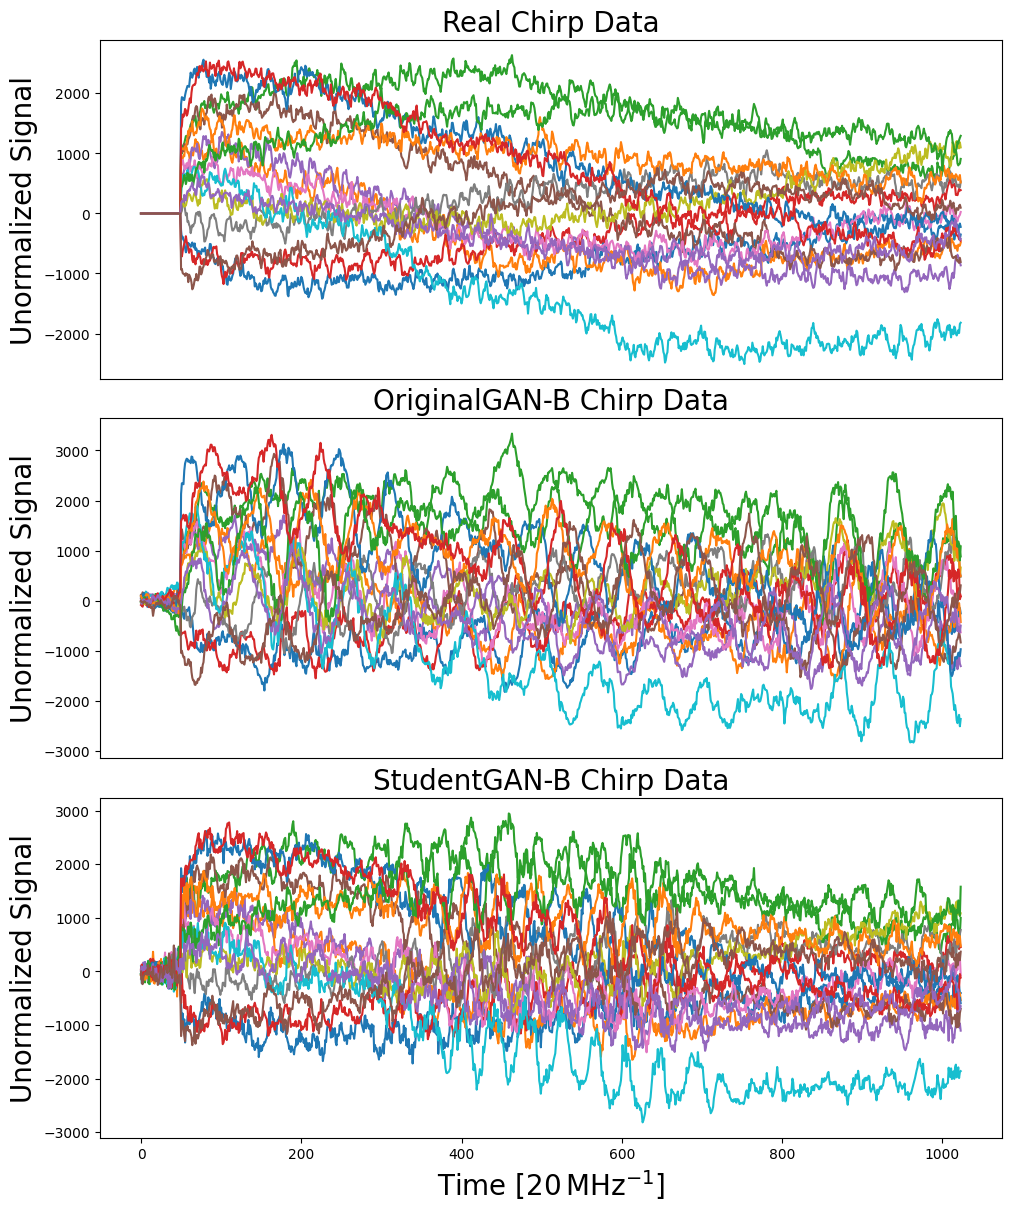

In [73]:
fig, axes = plt.subplots(3, 1, figsize=(10, 12), constrained_layout=True)

for ch in range(16):
    axes[0].plot(real_frame[:, ch])
axes[0].set_title("Real Chirp Data", fontsize=20)
axes[0].set_ylabel("Unormalized Signal", fontsize=20)
axes[0].set_xticks([])

for ch in range(16):
    axes[1].plot(original_frame_unnorm[:, ch])
axes[1].set_title("OriginalGAN-B Chirp Data", fontsize=20)
axes[1].set_ylabel("Unormalized Signal", fontsize=20)
axes[1].set_xticks([])

for ch in range(16):
    axes[2].plot(student_frame_unnorm[:, ch])
axes[2].set_title("StudentGAN-B Chirp Data", fontsize=20)
axes[2].set_ylabel("Unormalized Signal", fontsize=20)
axes[2].set_xlabel(r"Time [$20\,\mathrm{MHz}^{-1}$]", fontsize=20)

plt.savefig('/content/drive/MyDrive/cs231n/student-radar/paper/plots/raw_chirps_comparison.png', dpi=600)
plt.show()


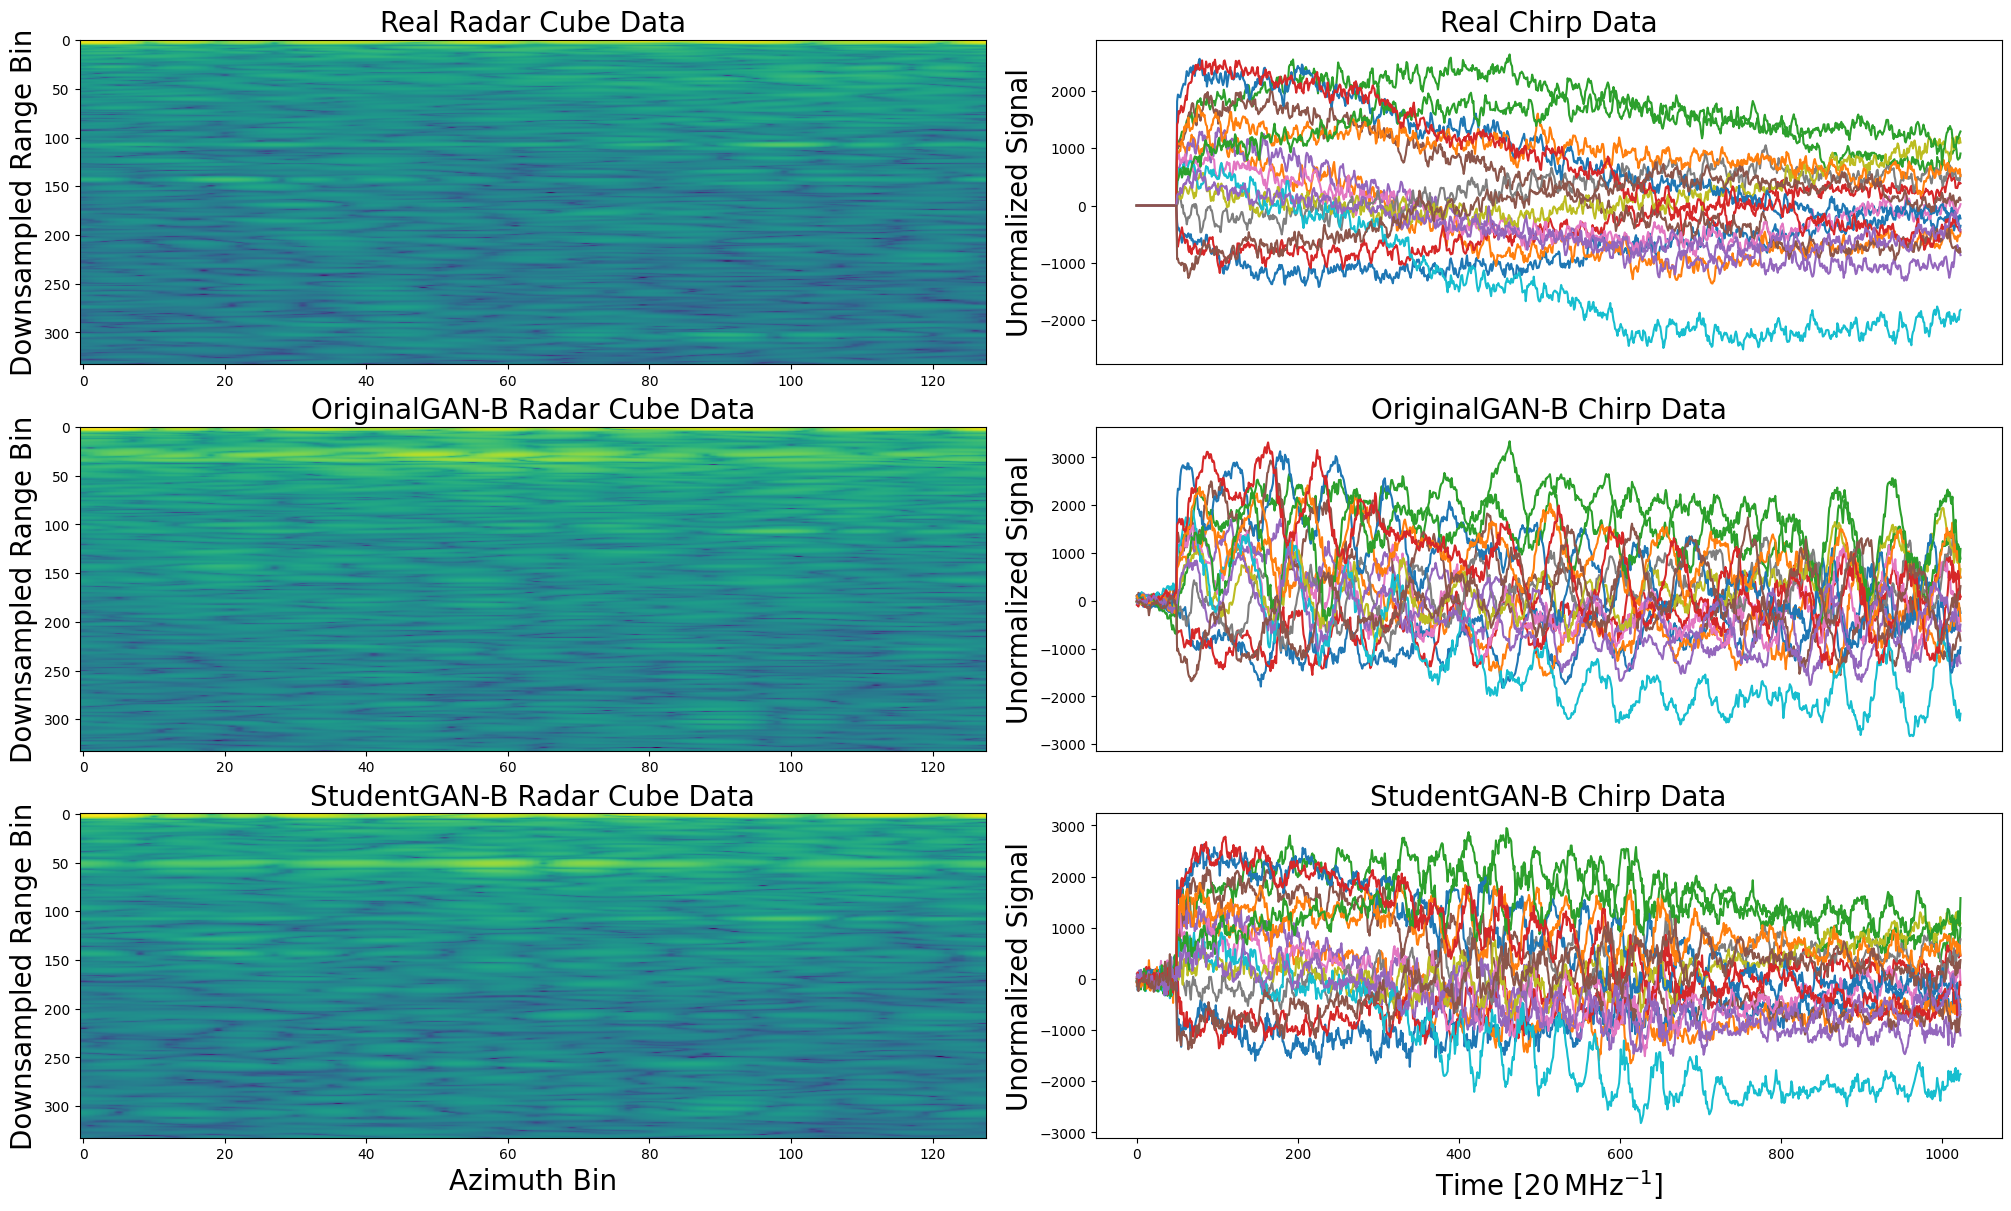

In [74]:
# import numpy as np
# import matplotlib.pyplot as plt

# # === Load RA maps ===
# real_ra = np.load('/content/drive/MyDrive/cs231n/student-radar/paper/data/real/real_ra.npy')
# original_ra = np.load('/content/drive/MyDrive/cs231n/student-radar/paper/data/generated/original_ra.npy')
# student_ra = np.load('/content/drive/MyDrive/cs231n/student-radar/paper/data/generated/student_ra.npy')

# # === Select frame ===
# frame_id = 0
# real_img = real_ra[frame_id]
# original_img = original_ra[frame_id]
# student_img = student_ra[frame_id]

# real_data_path = '/content/drive/MyDrive/cs231n/student-radar/paper/data/preprocessed/EXP_17_M_chirps.npy'
# original_data_path = '/content/drive/MyDrive/cs231n/student-radar/paper/data/generated/original/model-rghsxmf6/generations_10000/generator_data.npy'
# student_data_path = '/content/drive/MyDrive/cs231n/student-radar/paper/data/generated/student/model-h1k2x95j/generations_10000/generator_data.npy'

# real_data = np.load(real_data_path)
# original_data = np.load(original_data_path)
# student_data = np.load(student_data_path)

# frame_id = 0
# real_frame = real_data[frame_id].T
# original_frame = original_data[frame_id]
# student_frame = student_data[frame_id]

# a, b = -1, 1
# train_data_path = '/content/drive/MyDrive/cs231n/student-radar/paper/data/preprocessed/EXP_17_M_chirps_scaled_train.npy'
# train_data = np.load(train_data_path)

# data_min = train_data.min()
# data_max = train_data.max()


# def denormalize(x):
#     return data_min + (x - a) * (data_max - data_min) / (b - a)

# original_frame_unnorm = denormalize(original_frame).T
# student_frame_unnorm = denormalize(student_frame).T

# === Plot Combined Grid ===
fig, axes = plt.subplots(3, 2, figsize=(20, 12), constrained_layout=True)

# RA maps column (left)
axes[0,0].imshow(real_img, aspect='auto', cmap='viridis')
axes[0,0].set_title("Real Radar Cube Data", fontsize=20)
axes[0,0].set_ylabel("Downsampled Range Bin", fontsize=20)

axes[1,0].imshow(original_img, aspect='auto', cmap='viridis')
axes[1,0].set_title("OriginalGAN-B Radar Cube Data", fontsize=20)
axes[1,0].set_ylabel("Downsampled Range Bin", fontsize=20)

axes[2,0].imshow(student_img, aspect='auto', cmap='viridis')
axes[2,0].set_title("StudentGAN-B Radar Cube Data", fontsize=20)
axes[2,0].set_ylabel("Downsampled Range Bin", fontsize=20)
axes[2,0].set_xlabel("Azimuth Bin", fontsize=20)

for ch in range(16):
    axes[0,1].plot(real_frame[:, ch])
axes[0,1].set_title("Real Chirp Data", fontsize=20)
axes[0,1].set_ylabel("Unormalized Signal", fontsize=20)
axes[0,1].set_xticks([])

for ch in range(16):
    axes[1,1].plot(original_frame_unnorm[:, ch])
axes[1,1].set_title("OriginalGAN-B Chirp Data", fontsize=20)
axes[1,1].set_ylabel("Unormalized Signal", fontsize=20)
axes[1,1].set_xticks([])

for ch in range(16):
    axes[2,1].plot(student_frame_unnorm[:, ch])
axes[2,1].set_title("StudentGAN-B Chirp Data", fontsize=20)
axes[2,1].set_ylabel("Unormalized Signal", fontsize=20)
axes[2,1].set_xlabel(r"Time [$20\,\mathrm{MHz}^{-1}$]", fontsize=20)

# Save combined figure
plt.savefig('/content/drive/MyDrive/cs231n/student-radar/paper/plots/ra_signal_combined.png', dpi=600)
plt.show()
